In [0]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Mounted at /content/drive


In [0]:
% cd /content/drive/'My Drive'/Lunar-classification/DataSet/train
!ls

/content/drive/My Drive/Lunar-classification/DataSet/train
'Copy of CNN-Transfer_Learning.ipynb'   TrainImages
 output				       'Train Images.zip'


In [0]:
! pip install split-folders tqdm

In [0]:
# import split_folders

# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# split_folders.ratio('TrainImages', output="output", seed=1337, ratio=(.8, .2)) # default values

In [0]:
from pathlib import Path
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
from keras.applications.resnet50 import ResNet50, preprocess_input

### create a datagen for training

In [0]:
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "output/train"
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), batch_size=BATCH_SIZE)

Found 9598 images belonging to 2 classes.


In [0]:
train_steps = 9598//BATCH_SIZE

### create a datagen for testing

In [0]:
VALID_DIR = "output/val"
valid_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
#       rotation_range=90,
      horizontal_flip=True
#       vertical_flip=True
    )

valid_generator = valid_datagen.flow_from_directory(VALID_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
batch_size=BATCH_SIZE)

Found 2400 images belonging to 2 classes.


In [0]:
valid_steps = 2400//BATCH_SIZE

### create the network

In [0]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    # freeze the layers of the base model. We don't want to change the base feature extraction part
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    
    # we add our own classification part on top of the base model which is a combination of dense and dropout
    # followed by a softmax
    # the dense + dropout will add our own feature extraction which we can fine tune and classify
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [0]:
class_list = ['Small','Large']

In [0]:
FC_LAYERS = [1024, 1024]
dropout = 0.5

HEIGHT = 300
WIDTH = 300

# we use resnet50 as the base model without the top (means it doesn't have a FC + softmax/classifier on top)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, num_classes=len(class_list))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Choose optimizer

In [0]:
!ls

'Copy of CNN-Transfer_Learning.ipynb'   TrainImages
 output				       'Train Images.zip'


In [0]:
from keras.optimizers import SGD, Adam


BATCH_SIZE = 8
num_train_images = 500

adam = Adam(lr=0.0001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

### train the network

In [0]:
NUM_EPOCHS = 7

In [0]:
history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=train_steps, 
                                       validation_data=valid_generator, validation_steps=valid_steps,
                                       shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/7
1199/1199 [==============================] - 775s 646ms/step - loss: 0.9200 - acc: 0.9319 - val_loss: 6.4610 - val_acc: 0.5867
Epoch 2/7
1199/1199 [==============================] - 504s 420ms/step - loss: 0.6347 - acc: 0.9577 - val_loss: 7.2273 - val_acc: 0.5479
Epoch 3/7
1199/1199 [==============================] - 502s 419ms/step - loss: 0.5317 - acc: 0.9655 - val_loss: 6.1473 - val_acc: 0.6142
Epoch 4/7
1199/1199 [==============================] - 502s 419ms/step - loss: 0.6156 - acc: 0.9609 - val_loss: 1.7297 - val_acc: 0.8896
Epoch 5/7
1199/1199 [==============================] - 503s 419ms/step - loss: 0.5686 - acc: 0.9637 - val_loss: 1.1841 - val_acc: 0.9233
Epoch 6/7
1199/1199 [==============================] - 503s 419ms/step - loss: 0.5870 - acc: 0.9630 - val_loss: 3.6164 - val_acc: 0.7725
Epoch 7/7
1199/1199 [==============================] - 503s 419ms/step - loss: 0.573

In [0]:
finetune_model.save_weights('Lunar_classifier.hd5')

In [0]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

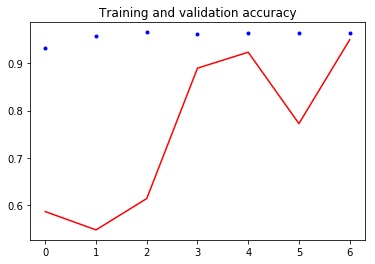

In [0]:
plot_training(history)

In [0]:
# test on our internal test set
TEST_BATCH_SIZE = 8
TEST_DIR = "output/val"
test_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = train_datagen.flow_from_directory(TEST_DIR, 
                                                   target_size=(HEIGHT, WIDTH), batch_size=TEST_BATCH_SIZE,class_mode='categorical',shuffle=False)

Found 2400 images belonging to 2 classes.


In [0]:
# finetune_model.load_weights("furniture_classifier.hd5")
losses = finetune_model.evaluate_generator(test_generator)
losses

[0.8605858489389664, 0.9458333333333333]

### Confusion Matrix

[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


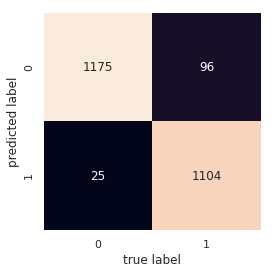

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
Y_pred = finetune_model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
mat = confusion_matrix(test_generator.classes, y_pred)
print(test_generator.classes)
print(y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');




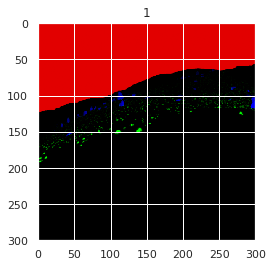

In [0]:
from keras.preprocessing import image
image_path="output/train/Small/ground5989.png" # output/train/Small/ground5999.png
img = image.load_img(image_path, target_size=(300,300))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=finetune_model.predict(img)
ch =int()
ch = 5
if(result[0][0] == 1):
  ch = 0
if(result[0][1] == 1):
  ch = 1
plt.title(ch)
plt.show()

In [0]:
!ls

'Copy of CNN-Transfer_Learning.ipynb'   output	     'Train Images.zip'
 Lunar_classifier.hd5		        TrainImages


### For Predicting


In [0]:
f = open("test.csv","r")
f1 = open("result.csv","w")
f1.write(f.readline())
# k = f.readlines()
count = 0
for j in range(0,7534):
  i = f.readline() 
  i = i.split(",")
  image_path="test/test/"+i[0] # output/train/Small/ground5999.png
  img = image.load_img(image_path, target_size=(300,300))
  img = np.expand_dims(img, axis=0)
  result=finetune_model.predict(img)
  
  if(result[0][0]>result[0][1]):
    f1.write(i[0]+","+"Large"+"\n")
    print(i[0],"Large")
    
  if(result[0][1]>result[0][0]):
    f1.write(i[0]+","+"Small"+"\n")
    print(i[0],"Small")
    

lg 988 (1).png Small
lg 988 (10).png Small
lg 988 (100).png Small
lg 988 (101).png Small
lg 988 (102).png Small
lg 988 (103).png Small
lg 988 (104).png Large
lg 988 (105).png Small
lg 988 (106).png Small
lg 988 (107).png Small
lg 988 (108).png Small
lg 988 (109).png Small
lg 988 (11).png Small
lg 988 (110).png Small
lg 988 (111).png Small
lg 988 (112).png Small
lg 988 (113).png Small
lg 988 (114).png Small
lg 988 (115).png Small
lg 988 (116).png Small
lg 988 (117).png Small
lg 988 (118).png Small
lg 988 (119).png Small
lg 988 (12).png Small
lg 988 (120).png Small
lg 988 (121).png Small
lg 988 (122).png Small
lg 988 (123).png Small
lg 988 (124).png Small
lg 988 (125).png Small
lg 988 (126).png Large
lg 988 (127).png Small
lg 988 (128).png Small
lg 988 (129).png Small
lg 988 (13).png Small
lg 988 (130).png Small
lg 988 (131).png Small
lg 988 (132).png Small
lg 988 (133).png Small
lg 988 (134).png Small
lg 988 (135).png Small
lg 988 (136).png Small
lg 988 (137).png Small
lg 988 (138).png 

In [0]:
!ls

'Copy of CNN-Transfer_Learning.ipynb'   result.csv   TrainImages
 Lunar_classifier.hd5		        test	    'Train Images.zip'
 output				        test.csv


In [0]:
!ls

'Copy of CNN-Transfer_Learning.ipynb'   result1.csv   test.csv
 Lunar_classifier.hd5		        result.csv    TrainImages
 output				        test	     'Train Images.zip'
